In [1]:
from IPython.display import clear_output

In [2]:
from google.colab import drive

drive.mount('/content/drive/')

clear_output()

In [3]:
import os
import re

import random

from operator import itemgetter, attrgetter
from itertools import islice
from collections import defaultdict

import numpy as np

from tqdm import tqdm

In [4]:
if not os.path.isdir('idao_dataset'):
    !pip install wldhx.yadisk-direct -qqq
    !curl -L $(yadisk-direct https://yadi.sk/d/UJ8DEma9LHRMsg) -o track_1.tar
    !tar xvf track_1.tar
    !rm track_1.tar

    !wget "https://s273vla.storage.yandex.net/rdisk/5419cbdff109b685f18f2cc128ca82fd3eafc9790a9dade7592e2785c3c246ef/60645441/bgrUSZap4U7F2FfQ-AWWcVCFnOObN1NGdFdocrjauwwvrixOJyYxAoSxQKitKzeuFt9xHujJSr2uP71e7TVa8Q==?uid=0&filename=track_1_private_test_final_27_03.zip&disposition=attachment&hash=OGTrMEeD15wCqdRSSwqp1R7gwsF1YKDyVMBb9IvYl2THpFxspvPSVhI6UMio3CQsq/J6bpmRyOJonT3VoXnDag%3D%3D%3A/track_1_private_test_final_27_03.zip&limit=0&content_type=application%2Fzip&owner_uid=44214498&fsize=2712019001&hid=3fb11601607208c5cf34a9916e16636d&media_type=compressed&tknv=v2&rtoken=LfpqCKeHIIxQ&force_default=no&ycrid=na-6c8a4c7a2dd99062d1da0f70b09b498a-downloader7e&ts=5bed2e69cd240&s=3c9ac0893d065ada7b35aa7d444f428318d4a30d3f8485a3a4b4c793686857cf&pb=U2FsdGVkX1-VFM7dK8YjxQ7PRXM7tbDHanBmNLz0LRsHke08s0ETpw5Tr-M111yPPdgpVZDuwbNnk69QnDuAuK2vA4bS5pE7fxAkxyqrB8Y" -O track_1_private_new.zip
    !unzip track_1_private_new.zip
    !rm -r __MACOSX
    !mv private_test idao_dataset/private_test_new
    !rm track_1_private_new.zip

clear_output()

In [5]:
DATA_DIR = "./idao_dataset/"
WORK_DIR = "/content/drive/My Drive/idao-2021"

In [6]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [7]:
import cv2

import albumentations as A

from skimage.measure import regionprops, label as regionlabel

from torch.utils.data.dataset import IterableDataset, Dataset

from PIL import Image
from multiprocessing import Pool, cpu_count

from pathlib import Path

from sklearn.model_selection import train_test_split, KFold


NUM_THREADS = cpu_count()

MAPPING_CLASS_INV = ['He_NR', 'ER']
MAPPING_CLASS = {v: k for k, v in enumerate(MAPPING_CLASS_INV)}

MAPPING_VALUE_INV = [1, 3, 6, 10, 20, 30]
MAPPING_VALUE = {v: k for k, v in enumerate(MAPPING_VALUE_INV)}
MAPPING_VALUE_INV = np.asarray(MAPPING_VALUE_INV)

IMG_SIZE_ORIGIN = 576
IMG_SIZE_ORIGIN_DIV_2 = IMG_SIZE_ORIGIN // 2

IMG_SIZE_SELECT = 120
IMG_SIZE_SELECT_DIV_2 = IMG_SIZE_SELECT // 2

kernel_5 = np.ones((5, 5), np.uint8)


def create_mask(img, thrsh=100, border=10):
    # mask = cv2.medianBlur(img, 3)
    mask = (img > thrsh).astype(np.uint8)

    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel_5)
    mask = cv2.dilate(mask, kernel_5, iterations=1)
    
    mask[:border, :] = mask[-border:, :] = 0
    mask[:, :border] = mask[:, -border:] = 0
    
    return mask


def fix_bbox(img_shape, bbox):
    y_min, x_min, y_max, x_max = bbox

    h_box, w_box = y_max - y_min, x_max - x_min
    h_max, w_max = img_shape

    assert h_box <= h_max and w_box <= w_max

    if y_min < 0:
        y_min, y_max = 0, h_box
    elif y_max > h_max:
        y_min, y_max = h_max - h_box, h_max

    if x_min < 0:
        x_min, x_max = 0, w_box
    elif x_max > w_max:
        x_min, x_max = w_max - w_box, w_max

    return y_min, x_min, y_max, x_max


def find_object_bbox(img, area_thrsh=150):
    img_mask = create_mask(img)
    img_mask = regionlabel(img_mask)
    
    props = regionprops(img_mask)
    props = sorted(props, key=attrgetter('area'), reverse=True)
    
    num_props = len(props)

    if num_props >= 1:
        prop = props[0]
        centroid_y, centroid_x = map(int, prop.centroid)
    else:
        centroid_y, centroid_x = IMG_SIZE_ORIGIN_DIV_2, IMG_SIZE_ORIGIN_DIV_2

    y_min, x_min, y_max, x_max = (
        centroid_y - IMG_SIZE_SELECT_DIV_2,
        centroid_x - IMG_SIZE_SELECT_DIV_2,
        centroid_y + IMG_SIZE_SELECT_DIV_2,
        centroid_x + IMG_SIZE_SELECT_DIV_2,
    )

    bbox = x_min, y_min, x_max, y_max
    bbox = fix_bbox(img.shape, bbox)
    return bbox


def process_image(img_path):
    img_name = os.path.basename(img_path)
    img_name_re = re.search('__CYGNO_\d+_\d+_(\w*)_(\d+)_keV', img_name)
    if img_name_re:
        img_class = MAPPING_CLASS[img_name_re.group(1)]
        img_value = MAPPING_VALUE[int(img_name_re.group(2))]
    else:
        img_class, img_value = None, None

    img = np.asarray(Image.open(img_path))
    x_min, y_min, x_max, y_max = find_object_bbox(img)
    img = img[y_min:y_max, x_min:x_max]
    img = cv2.medianBlur(img, ksize=3)

    return img, img_class, img_value, img_name


class IDAODataset(Dataset):
    def __init__(self, images, labels, values, filenames, batch_size=128,
                 transform=None, apply_transform_optional=True, random_state=None):
        super(IDAODataset, self).__init__()

        self.images = images
        self.labels = labels
        self.values = values

        self.filenames = filenames
        
        self.random_state = np.random.RandomState(random_state)
        self.indices = np.arange(len(self.images))
        self.batch_size = batch_size

        self.transform = transform
        self.transform_fn = self.create_transform_fn(transform, apply_transform_optional)

    def create_transform_fn(self, transform, apply_transform_optional):
        if transform is None:
            return None

        transform = [tr for tr, is_required in transform
                     if is_required or apply_transform_optional]
        
        if not transform:
            return None

        return A.Compose(transform)

    def __getitem__(self, idx):
        if idx < 0:
            idx = len(self) + idx

        if not (0 <= idx < len(self)):
            raise IndexError(idx)

        offset_beg, offset_end = idx * self.batch_size, (idx + 1) * self.batch_size
        item_slice = self.indices[offset_beg:offset_end]

        images = self.images[item_slice]

        if self.transform_fn is not None:
            images = [self.transform_fn(image=image)["image"] for image in images]

        images = np.asarray(images)
        images = torch.tensor(images, dtype=torch.float, device=device).unsqueeze(1)

        if self.labels is not None and self.values is not None:
            labels = torch.tensor(self.labels[item_slice], dtype=torch.float, device=device).unsqueeze(-1)
            values = torch.tensor(self.values[item_slice], dtype=torch.long, device=device)
        else:
            labels, values = None, None

        return (images, labels, values)

    def __len__(self):
        return int(np.ceil(self.indices.shape[0] / self.batch_size))

    def shuffle(self):
        self.random_state.shuffle(self.indices)

    def set_random_state(self, random_state=None):
        self.random_state = np.random.RandomState(random_state)

    @classmethod
    def from_path(cls, path, batch_size=128, transform=None, apply_transform_optional=True,
                  has_target=True, random_state=None):
        with Pool(processes=NUM_THREADS) as pool:
            images_paths = Path(path).rglob('*.png')
            images_paths = sorted(map(str, images_paths))
            images = pool.imap(process_image, tqdm(images_paths, position=0), chunksize=10)
            images = list(images)

        return cls(
            images=np.asarray([img for img, _, _, _ in images]),
            labels=np.asarray([cls for _, cls, _, _ in images]) if has_target else None,
            values=np.asarray([val for _, _, val, _ in images]) if has_target else None,
            filenames=np.asarray([name for _, _, _, name in images]),
            batch_size=batch_size,
            transform=transform,
            apply_transform_optional=apply_transform_optional,
            random_state=random_state,
        )

    def _train_test_split(self, indices_train, indices_test):
        cls = type(self)
        
        dataset_train = cls(
            images=self.images,
            labels=self.labels,
            values=self.values,
            filenames=self.filenames,
            transform=self.transform,
            apply_transform_optional=True,
            batch_size=self.batch_size,
        )

        dataset_test = cls(
            images=self.images,
            labels=self.labels,
            values=self.values,
            filenames=self.filenames,
            transform=self.transform,
            apply_transform_optional=False,
            batch_size=self.batch_size,
        )

        # ad hoc for no copy in fancy indexing
        dataset_train.indices = self.indices[indices_train]
        dataset_test.indices  = self.indices[indices_test]

        return dataset_train, dataset_test

    def split(self, test_size=0.3, random_state=None):
        indices_train, indices_test = train_test_split(
            self.indices, test_size=test_size, random_state=random_state)
        return self._train_test_split(indices_train, indices_test)

    def cv_split(self, n_splits=5, shuffle=True, random_state=None):
        kf = KFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)
        for indices_train, indices_test in kf.split(self.indices):
            yield self._train_test_split(indices_train, indices_test)

In [8]:
%%time

random.seed(68)

try:
    dataset = IDAODataset(
        images=dataset.images,
        labels=dataset.labels,
        values=dataset.values,
        filenames=dataset.filenames,
        transform=dataset.transform,
        apply_transform_optional=True,
        batch_size=dataset.batch_size,
    )
except NameError as e:
    print(e)

    dataset = IDAODataset.from_path(
        path='idao_dataset/train/',
        transform=[
            (A.Flip(p=0.25), False),
            (A.RandomRotate90(p=0.25), False),
        ],
        apply_transform_optional=True,
        has_target=True,
    )

dataset_folds = list(dataset.cv_split(random_state=42))

for train, valid in dataset_folds:
    train.set_random_state(9872)
    valid.set_random_state(9872)

len(dataset_folds)

name 'dataset' is not defined


100%|██████████| 13404/13404 [01:14<00:00, 179.36it/s]


CPU times: user 2.45 s, sys: 921 ms, total: 3.37 s
Wall time: 1min 18s


In [9]:
import torch.nn as nn
import torch.nn.functional as F


class IDAONet(nn.Module):
    def __init__(self):
        super(IDAONet, self).__init__()

        self._conv = nn.Sequential(
            nn.BatchNorm2d(1),

            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            
            nn.MaxPool2d(kernel_size=3),

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=3),

            nn.Flatten(),
            nn.ReLU(),
        )

        self._cls_labels = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(6272, 500),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(500, 1),
        )

        self._cls_values = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(6272, 500),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(500, len(MAPPING_VALUE_INV)),
        )

    def forward(self, images):
        images = self._conv(images)
        labels = self._cls_labels(images)
        values = self._cls_values(images)
        return labels, values

In [10]:
net = IDAONet().to(device)
net

IDAONet(
  (_conv): Sequential(
    (0): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): ReLU()
  )
  (_cls_labels): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=6272, out_features=500, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=500, out_features=1, bias=True)
  )
  (_cls_values): Sequential(
    (0): Dr

In [11]:
def train_func(model: nn.Module, iterator, criteria, optimizer, verbose=True):
    epoch_loss = 0
    num_samples = 0
    
    criterion_labels, criterion_values = criteria

    iterator.shuffle()
    model.train()
    
    if verbose:
        iterator = tqdm(iterator, position=0, desc='batches')

    for images, labels_true, values_true in iterator:
        optimizer.zero_grad()

        labels_pred, values_pred = model(images)

        loss = criterion_labels(labels_pred, labels_true) + \
               criterion_values(values_pred, values_true)
        loss.backward()

        epoch_loss += loss.item()
        num_samples += images.shape[0]

        optimizer.step()

    return epoch_loss / num_samples, np.nan

In [12]:
from sklearn.metrics import roc_auc_score, mean_absolute_error
from sklearn.metrics import roc_curve


def evaluate_func(model: nn.Module, iterator, verbose=True, return_misclassified=False):
    epoch_loss = 0
    num_samples = 0

    model.eval()

    if verbose:
        iterator_ = tqdm(iterator, position=0, desc='batches')
    else:
        iterator_ = iterator
    
    labels_pred_all, values_pred_all = [], []

    with torch.no_grad():
        for images, labels_true, values_true in iterator_:
            labels_pred, values_pred = model(images)
            labels_pred = torch.sigmoid(labels_pred)

            labels_pred = labels_pred.cpu().detach().numpy().ravel()
            values_pred = values_pred.cpu().detach().numpy().argmax(axis=1).ravel()

            labels_pred_all.append(labels_pred)
            values_pred_all.append(values_pred)

    labels_pred = np.concatenate(labels_pred_all)
    values_pred = np.concatenate(values_pred_all)

    labels_true = iterator.labels[iterator.indices]
    values_true = iterator.values[iterator.indices]

    values_pred = MAPPING_VALUE_INV[values_pred]
    values_true = MAPPING_VALUE_INV[values_true]

    score_auc = roc_auc_score(labels_true, labels_pred)
    score_mae = mean_absolute_error(values_true, values_pred)

    metrics = {'auc': score_auc, 'mae': score_mae}
    score = score_auc - score_mae

    if return_misclassified:
        fpr, tpr, thresholds = roc_curve(labels_true, labels_pred)
        threshold_best = thresholds[np.argmax(tpr - fpr)]

        errors = ((labels_true - (labels_pred > threshold_best)) != 0).astype(int) * 1 + \
                 ((values_true - values_pred) != 0).astype(int) * 2
        mask = errors > 0
        return iterator.filenames[iterator.indices[mask]], errors[mask]

    return np.nan, score, metrics

In [13]:
import torch.optim as optim

criteria = [
    torch.nn.BCEWithLogitsLoss(reduction='sum'),
    torch.nn.CrossEntropyLoss(reduction='sum'),
]

optimizer = optim.Adam(lr=0.001, params=net.parameters())

In [14]:
CHECKPOINTS = os.path.join(WORK_DIR, "checkpoints_2")

!rm -r "{CHECKPOINTS}" || true
!mkdir -p "{CHECKPOINTS}"

for fold, _ in enumerate(dataset_folds, 1):
    !mkdir -p "{CHECKPOINTS}/fold_{fold}"

!ls -l "{CHECKPOINTS}"

rm: cannot remove '/content/drive/My Drive/idao-2021/checkpoints_2': No such file or directory
total 20
drwx------ 2 root root 4096 Mar 31 08:30 fold_1
drwx------ 2 root root 4096 Mar 31 08:30 fold_2
drwx------ 2 root root 4096 Mar 31 08:30 fold_3
drwx------ 2 root root 4096 Mar 31 08:30 fold_4
drwx------ 2 root root 4096 Mar 31 08:30 fold_5


In [15]:
class EarlyStopping:
    def __init__(self, max_attempt=5):
        self.attempt = -1
        self.max_attempt = max_attempt
        
        self.best_score = -1
        self.best_attempt = -1

    def add_score(self, score):
        self.attempt += 1

        if self.best_score < score:
            self.best_score = score
            self.best_attempt = self.attempt

    def is_valid(self):
        return (self.attempt - self.best_attempt) <= self.max_attempt

In [16]:
NUM_EPOCHS = 30


es = EarlyStopping(max_attempt=10)


def weight_reset(m):
    reset_parameters = getattr(m, "reset_parameters", None)
    if callable(reset_parameters):
        m.reset_parameters()


params = {
    'criteria': criteria,
    'optimizer': optimizer,
    'verbose': False,
}


STR_OFFSET = ' ' * 11


for epoch in range(NUM_EPOCHS):
    scores = defaultdict(list)

    for fold, (train, valid) in enumerate(tqdm(dataset_folds), 1):
        model_prev = os.path.join(CHECKPOINTS, f'fold_{fold}', f'model_iter_{epoch}.model')
        model_next = os.path.join(CHECKPOINTS, f'fold_{fold}', f'model_iter_{epoch+1}.model')

        is_trained = os.path.isfile(model_next)

        if not is_trained:
            if epoch > 0:
                net.load_state_dict(torch.load(model_prev))
            else:
                net.apply(weight_reset)

            train_loss, train_score = train_func(net, train, **params)
            torch.save(net.state_dict(), model_next)
        else:
            net.load_state_dict(torch.load(model_next))
            train_loss, train_score = np.nan, np.nan

        valid_loss, valid_score, valid_metrics = evaluate_func(net, valid, verbose=False)
        
        scores['train_loss'].append(train_loss)
        scores['valid_loss'].append(valid_loss)

        scores['train_score'].append(train_score)
        scores['valid_score'].append(valid_score)

        for k, v in valid_metrics.items():
            scores['valid_' + k].append(v)

    train_loss, train_score = np.mean(scores['train_loss']), np.mean(scores['train_score'])
    valid_loss, valid_score = np.mean(scores['valid_loss']), np.mean(scores['valid_score'])
    
    valid_auc, valid_mae = np.mean(scores['valid_auc']), np.mean(scores['valid_mae'])

    print()
    print(f"Epoch = {epoch+1:02d}; "
          f"Train Loss: {train_loss:.6f}; Train Score: {train_score:.6f}; "
          f"Val. Loss: {valid_loss:.6f}; Val. Score: {valid_score:.6f}")
    print(STR_OFFSET, f"Val. AUC: {valid_auc:.6f}; Val. MAE: {valid_mae:.6f}")

    es.add_score(valid_score)
    if not es.is_valid():
        break

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch = 01; Train Loss: 1.308162; Train Score: nan; Val. Loss: nan; Val. Score: 0.869425
            Val. AUC: 0.997296; Val. MAE: 0.127870


  0%|          | 0/5 [00:00<?, ?it/s]


Epoch = 02; Train Loss: 0.260613; Train Score: nan; Val. Loss: nan; Val. Score: 0.943582
            Val. AUC: 0.998638; Val. MAE: 0.055056


  0%|          | 0/5 [00:00<?, ?it/s]


Epoch = 03; Train Loss: 0.137642; Train Score: nan; Val. Loss: nan; Val. Score: 0.965003
            Val. AUC: 0.998574; Val. MAE: 0.033571


  0%|          | 0/5 [00:00<?, ?it/s]


Epoch = 04; Train Loss: 0.103785; Train Score: nan; Val. Loss: nan; Val. Score: 0.970078
            Val. AUC: 0.999174; Val. MAE: 0.029096


  0%|          | 0/5 [00:00<?, ?it/s]


Epoch = 05; Train Loss: 0.089794; Train Score: nan; Val. Loss: nan; Val. Score: 0.963929
            Val. AUC: 0.999142; Val. MAE: 0.035213


  0%|          | 0/5 [00:00<?, ?it/s]


Epoch = 06; Train Loss: 0.084846; Train Score: nan; Val. Loss: nan; Val. Score: 0.974531
            Val. AUC: 0.999149; Val. MAE: 0.024618


  0%|          | 0/5 [00:00<?, ?it/s]


Epoch = 07; Train Loss: 0.081846; Train Score: nan; Val. Loss: nan; Val. Score: 0.966174
            Val. AUC: 0.999148; Val. MAE: 0.032975


  0%|          | 0/5 [00:00<?, ?it/s]


Epoch = 08; Train Loss: 0.075537; Train Score: nan; Val. Loss: nan; Val. Score: 0.972362
            Val. AUC: 0.999071; Val. MAE: 0.026708


  0%|          | 0/5 [00:00<?, ?it/s]


Epoch = 09; Train Loss: 0.069528; Train Score: nan; Val. Loss: nan; Val. Score: 0.977178
            Val. AUC: 0.998962; Val. MAE: 0.021784


  0%|          | 0/5 [00:00<?, ?it/s]


Epoch = 10; Train Loss: 0.072948; Train Score: nan; Val. Loss: nan; Val. Score: 0.973588
            Val. AUC: 0.999401; Val. MAE: 0.025814


  0%|          | 0/5 [00:00<?, ?it/s]


Epoch = 11; Train Loss: 0.071167; Train Score: nan; Val. Loss: nan; Val. Score: 0.970234
            Val. AUC: 0.999106; Val. MAE: 0.028872


  0%|          | 0/5 [00:00<?, ?it/s]


Epoch = 12; Train Loss: 0.071236; Train Score: nan; Val. Loss: nan; Val. Score: 0.975265
            Val. AUC: 0.999288; Val. MAE: 0.024023


  0%|          | 0/5 [00:00<?, ?it/s]


Epoch = 13; Train Loss: 0.074908; Train Score: nan; Val. Loss: nan; Val. Score: 0.973479
            Val. AUC: 0.999292; Val. MAE: 0.025813


  0%|          | 0/5 [00:00<?, ?it/s]


Epoch = 14; Train Loss: 0.059756; Train Score: nan; Val. Loss: nan; Val. Score: 0.970642
            Val. AUC: 0.999143; Val. MAE: 0.028501


  0%|          | 0/5 [00:00<?, ?it/s]


Epoch = 15; Train Loss: 0.059097; Train Score: nan; Val. Loss: nan; Val. Score: 0.978632
            Val. AUC: 0.999296; Val. MAE: 0.020665


  0%|          | 0/5 [00:00<?, ?it/s]


Epoch = 16; Train Loss: 0.059386; Train Score: nan; Val. Loss: nan; Val. Score: 0.975153
            Val. AUC: 0.999326; Val. MAE: 0.024173


  0%|          | 0/5 [00:00<?, ?it/s]


Epoch = 17; Train Loss: 0.057876; Train Score: nan; Val. Loss: nan; Val. Score: 0.975578
            Val. AUC: 0.999302; Val. MAE: 0.023723


  0%|          | 0/5 [00:00<?, ?it/s]


Epoch = 18; Train Loss: 0.056584; Train Score: nan; Val. Loss: nan; Val. Score: 0.976704
            Val. AUC: 0.999235; Val. MAE: 0.022530


  0%|          | 0/5 [00:00<?, ?it/s]


Epoch = 19; Train Loss: 0.054595; Train Score: nan; Val. Loss: nan; Val. Score: 0.972004
            Val. AUC: 0.999533; Val. MAE: 0.027529


  0%|          | 0/5 [00:00<?, ?it/s]


Epoch = 20; Train Loss: 0.050890; Train Score: nan; Val. Loss: nan; Val. Score: 0.979066
            Val. AUC: 0.999657; Val. MAE: 0.020591


  0%|          | 0/5 [00:00<?, ?it/s]


Epoch = 21; Train Loss: 0.047692; Train Score: nan; Val. Loss: nan; Val. Score: 0.968960
            Val. AUC: 0.999549; Val. MAE: 0.030588


  0%|          | 0/5 [00:00<?, ?it/s]


Epoch = 22; Train Loss: 0.046234; Train Score: nan; Val. Loss: nan; Val. Score: 0.966122
            Val. AUC: 0.999545; Val. MAE: 0.033423


  0%|          | 0/5 [00:00<?, ?it/s]


Epoch = 23; Train Loss: 0.052649; Train Score: nan; Val. Loss: nan; Val. Score: 0.965792
            Val. AUC: 0.999589; Val. MAE: 0.033797


  0%|          | 0/5 [00:00<?, ?it/s]


Epoch = 24; Train Loss: 0.054422; Train Score: nan; Val. Loss: nan; Val. Score: 0.970306
            Val. AUC: 0.999475; Val. MAE: 0.029169


  0%|          | 0/5 [00:00<?, ?it/s]


Epoch = 25; Train Loss: 0.044824; Train Score: nan; Val. Loss: nan; Val. Score: 0.965163
            Val. AUC: 0.999479; Val. MAE: 0.034316


  0%|          | 0/5 [00:00<?, ?it/s]


Epoch = 26; Train Loss: 0.040521; Train Score: nan; Val. Loss: nan; Val. Score: 0.977387
            Val. AUC: 0.999322; Val. MAE: 0.021935


  0%|          | 0/5 [00:00<?, ?it/s]


Epoch = 27; Train Loss: 0.047593; Train Score: nan; Val. Loss: nan; Val. Score: 0.984379
            Val. AUC: 0.999599; Val. MAE: 0.015220


  0%|          | 0/5 [00:00<?, ?it/s]


Epoch = 28; Train Loss: 0.038095; Train Score: nan; Val. Loss: nan; Val. Score: 0.984973
            Val. AUC: 0.999671; Val. MAE: 0.014698


  0%|          | 0/5 [00:00<?, ?it/s]


Epoch = 29; Train Loss: 0.040660; Train Score: nan; Val. Loss: nan; Val. Score: 0.978664
            Val. AUC: 0.999331; Val. MAE: 0.020667


100%|██████████| 5/5 [00:34<00:00,  6.98s/it]


Epoch = 30; Train Loss: 0.038610; Train Score: nan; Val. Loss: nan; Val. Score: 0.975219
            Val. AUC: 0.999466; Val. MAE: 0.024247


In [17]:
'%.6f' % es.best_score

'0.984973'

In [18]:
epoch_best = es.best_attempt + 1
model_best = os.path.join(CHECKPOINTS, f'fold_{fold}', f'model_iter_{epoch_best}.model')

model_best

'/content/drive/My Drive/idao-2021/checkpoints_2/fold_5/model_iter_28.model'

In [19]:
net.load_state_dict(torch.load(model_best))
net

IDAONet(
  (_conv): Sequential(
    (0): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): ReLU()
  )
  (_cls_labels): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=6272, out_features=500, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=500, out_features=1, bias=True)
  )
  (_cls_values): Sequential(
    (0): Dr

In [20]:
class HookRegister:
    def __init__(self, module):
        self.output = None
        self.hook = module.register_forward_hook(self.hook_fn)

    def hook_fn(self, module, grad_in, grad_out):
        self.output = grad_out

    def close(self):
        self.hook.remove()

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.close()


class CNNLayerVisualization:
    def __init__(self, model, selected_layer, selected_filter, seed=None):
        self.model = model
        self.selected_layer = selected_layer
        self.selected_filter = selected_filter
        self.selected_output = None
        self.random_state = np.random.RandomState(seed)

    def visualise(self, optimizer, opt_steps=32):
        random_image = np.uint8(self.random_state.uniform(50, 160, (120, 120)))
        random_image = random_image[np.newaxis, np.newaxis, :]
        random_image = torch.tensor(random_image, dtype=torch.float, device=device)

        self.model.eval()

        with HookRegister(self.selected_layer) as hook:
            for i in range(opt_steps):
                optimizer.zero_grad()
                _ = self.model(random_image)
                
                loss = -hook.output[:, self.selected_filter].mean()
                loss.backward()
                optimizer.step()
            
            self.selected_output = hook.output[0, self.selected_filter]

        return self.selected_output

In [21]:
num_filters = 16
out_filters = []

for selected_filter in range(num_filters):
    visio = CNNLayerVisualization(
        model=net,
        selected_layer=list(net._conv.children())[1],
        selected_filter=selected_filter,
        # seed=1932,
    )

    res = visio.visualise(optimizer, opt_steps=32)
    res = res.cpu().detach().numpy()

    out_filters.append(res)

In [22]:
from itertools import chain, zip_longest

import matplotlib.pyplot as plt

%matplotlib inline

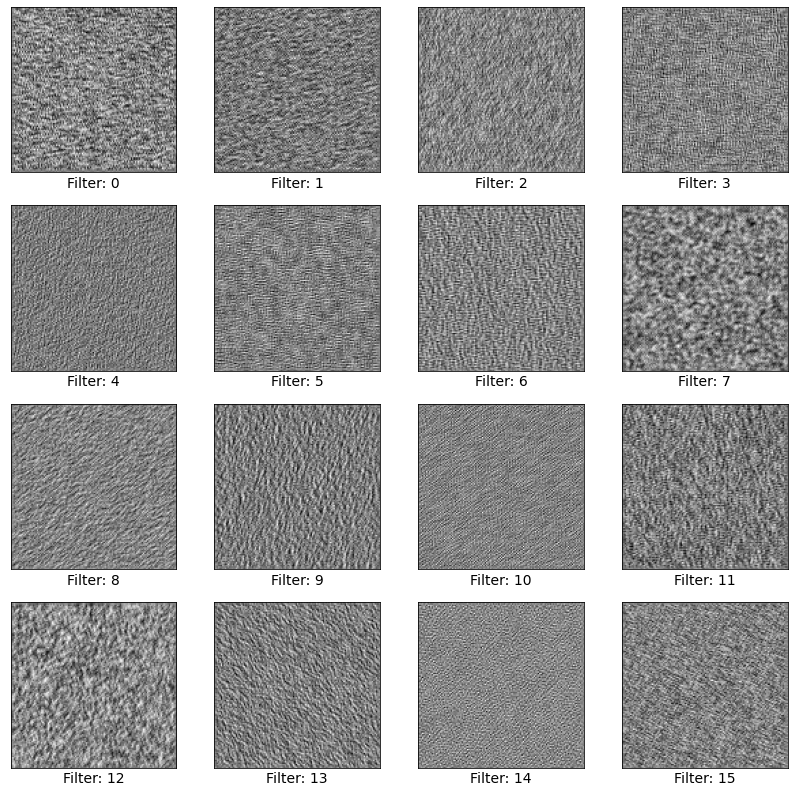

In [23]:
fig, axes = plt.subplots(4, 4, figsize=(14, 14))

for i, (ax, img) in enumerate(zip_longest(chain.from_iterable(axes), out_filters)):
    if ax is None:
        break
    
    if img is not None:
        _ = ax.imshow(img, cmap='gray')
    
    _ = ax.set_yticklabels([])
    _ = ax.set_xticklabels([])
    _ = ax.set_yticks([])
    _ = ax.set_xticks([])

    _ = ax.set_xlabel(f'Filter: {i}', fontsize=14)
    _ = ax.set(aspect='equal')

In [24]:
num_filters = 32
out_filters = []

for selected_filter in range(num_filters):
    visio = CNNLayerVisualization(
        model=net,
        selected_layer=list(net._conv.children())[5],
        selected_filter=selected_filter,
        # seed=1932,
    )

    res = visio.visualise(optimizer, opt_steps=32)
    res = res.cpu().detach().numpy()

    out_filters.append(res)

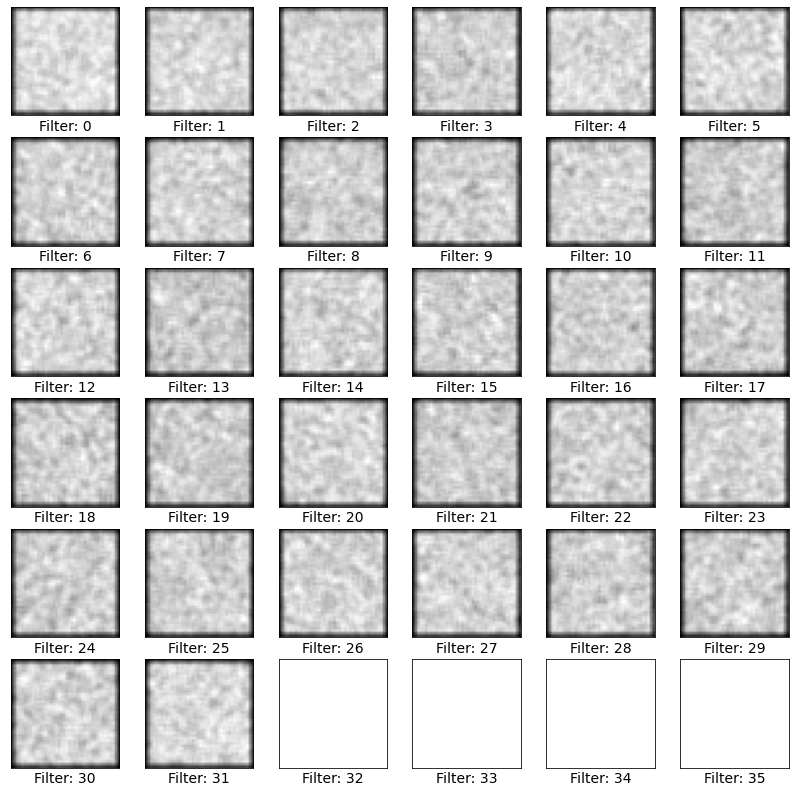

In [25]:
fig, axes = plt.subplots(6, 6, figsize=(14, 14))

for i, (ax, img) in enumerate(zip_longest(chain.from_iterable(axes), out_filters)):
    if ax is None:
        break
    
    if img is not None:
        _ = ax.imshow(img, cmap='gray')
    
    _ = ax.set_yticklabels([])
    _ = ax.set_xticklabels([])
    _ = ax.set_yticks([])
    _ = ax.set_xticks([])

    _ = ax.set_xlabel(f'Filter: {i}', fontsize=14)
    _ = ax.set(aspect='equal')

In [26]:
misclassified, errors = evaluate_func(net, valid, return_misclassified=True)
misclassified[:5], errors[:5]

batches: 100%|██████████| 21/21 [00:00<00:00, 50.41it/s]


(array(['-0.0031084376387298107__CYGNO_60_40_ER_3_keV_930V_30cm_IDAO_iso_crop_hist_pic_run5_ev860;1.png',
        '-0.004240238573402166__CYGNO_60_40_ER_3_keV_930V_30cm_IDAO_iso_crop_hist_pic_run5_ev702;1.png',
        '-0.005811686161905527__CYGNO_60_40_ER_3_keV_930V_30cm_IDAO_iso_crop_hist_pic_run5_ev953;1.png',
        '-0.007106146775186062__CYGNO_60_40_ER_30_keV_930V_30cm_IDAO_iso_crop_hist_pic_run2_ev266;1.png',
        '-0.008188566192984581__CYGNO_60_40_ER_10_keV_930V_30cm_IDAO_iso_crop_hist_pic_run3_ev479;1.png'],
       dtype='<U103'), array([3, 3, 3, 3, 3]))

In [27]:
np.bincount(errors, minlength=4), errors.shape

(array([  0, 322, 907, 994]), (2223,))

In [28]:
misclassified[errors == 3][:10]

array(['-0.0031084376387298107__CYGNO_60_40_ER_3_keV_930V_30cm_IDAO_iso_crop_hist_pic_run5_ev860;1.png',
       '-0.004240238573402166__CYGNO_60_40_ER_3_keV_930V_30cm_IDAO_iso_crop_hist_pic_run5_ev702;1.png',
       '-0.005811686161905527__CYGNO_60_40_ER_3_keV_930V_30cm_IDAO_iso_crop_hist_pic_run5_ev953;1.png',
       '-0.007106146775186062__CYGNO_60_40_ER_30_keV_930V_30cm_IDAO_iso_crop_hist_pic_run2_ev266;1.png',
       '-0.008188566192984581__CYGNO_60_40_ER_10_keV_930V_30cm_IDAO_iso_crop_hist_pic_run3_ev479;1.png',
       '-0.008852096274495125__CYGNO_60_40_ER_3_keV_930V_30cm_IDAO_iso_crop_hist_pic_run2_ev276;1.png',
       '-0.011505973525345325__CYGNO_60_40_ER_3_keV_930V_30cm_IDAO_iso_crop_hist_pic_run2_ev814;1.png',
       '-0.01979830116033554__CYGNO_60_40_ER_3_keV_930V_30cm_IDAO_iso_crop_hist_pic_run3_ev838;1.png',
       '-0.0294750165194273__CYGNO_60_40_ER_10_keV_930V_30cm_IDAO_iso_crop_hist_pic_run5_ev425;1.png',
       '-0.034648627042770386__CYGNO_60_40_ER_30_keV_930V_30cm_

In [29]:
import pandas as pd


def make_submission(model, iterator, verbose=True):
    model.eval()

    filenames_all = []
    labels_pred_all, values_pred_all = [], []

    if verbose:
        iterator_ = tqdm(iterator, position=0)
    else:
        iterator_ = iterator

    with torch.no_grad():
        for images, *_ in iterator_:
            images = images.to(device)
            labels_pred, values_pred = model(images)

            labels_pred = torch.sigmoid(labels_pred)
            labels_pred = labels_pred.cpu().detach().numpy().ravel()
            values_pred = values_pred.cpu().detach().numpy().argmax(axis=1).ravel()

            labels_pred_all.append(labels_pred)
            values_pred_all.append(values_pred)

    labels_pred = np.concatenate(labels_pred_all)
    values_pred = np.concatenate(values_pred_all)
    values_pred = MAPPING_VALUE_INV[values_pred]
    
    submission = pd.DataFrame()
    submission['id'] = iterator.filenames
    submission['classification_predictions'] = labels_pred
    submission['regression_predictions'] = values_pred

    submission['id'] = submission['id'].str.split('.').str[0]
    submission.set_index('id', inplace=True)

    return submission

In [30]:
%%time

dataset_public = IDAODataset.from_path(
    path='idao_dataset/public_test/',
    transform=dataset.transform,
    apply_transform_optional=False,
    has_target=False,
)

dataset_private = IDAODataset.from_path(
    path='idao_dataset/private_test/',
    transform=dataset.transform,
    apply_transform_optional=False,
    has_target=False,
)

100%|██████████| 15062/15062 [01:20<00:00, 187.40it/s]


CPU times: user 2.38 s, sys: 1.18 s, total: 3.56 s
Wall time: 1min 33s


In [31]:
submission_pull = []

for fold in range(1, len(dataset_folds) + 1):
    model_best = os.path.join(CHECKPOINTS, f'fold_{fold}', f'model_iter_{epoch_best}.model')
    net.load_state_dict(torch.load(model_best))

    submission_pub = make_submission(net, dataset_public)
    submission_prv = make_submission(net, dataset_private)

    submission = pd.concat([submission_pub, submission_prv], axis=0)
    submission = submission.add_suffix(f'_{fold}')
    submission_pull.append(submission)

submission_pull = pd.concat(submission_pull, axis=1)

submission = pd.DataFrame(index=submission_pull.index)

mask = submission_pull.columns.str.startswith('classification_predictions_')
submission['classification_predictions'] = submission_pull.loc[:, mask].mean(axis=1).values

mask = submission_pull.columns.str.startswith('regression_predictions_')
submission['regression_predictions'] = submission_pull.loc[:, mask].mode(axis=1).mean(axis=1).values.astype(int)

submission.head()

100%|██████████| 118/118 [00:02<00:00, 51.44it/s]


,classification_predictions,regression_predictions
id,,
001ec8f4d2679f2899a63e4b2597c0a10bd9393f,0.000231,20
00327390bfd6101b87106e96e0efc1c938690e1f,0.000472,6
00573dde8addbac780cfa35a55a790fa1aa45178,0.000218,20
00cb5b91a4acdfaa2f55dc2266e598ff06f9209e,0.000594,6
00de1146bdcbfb02ed5f0e13fd6b9fe62157c0b2,0.001235,6


In [32]:
submission.shape

(16564, 2)

In [33]:
submission_name = os.path.join(WORK_DIR, 'submission_004-2_old.csv')
submission.to_csv(submission_name, index=True)

In [34]:
dataset_private = IDAODataset.from_path(
    path='idao_dataset/private_test_new/',
    transform=dataset.transform,
    apply_transform_optional=False,
    has_target=False,
)

100%|██████████| 15058/15058 [01:30<00:00, 166.63it/s]


In [35]:
submission_pull = []

for fold in range(1, len(dataset_folds) + 1):
    model_best = os.path.join(CHECKPOINTS, f'fold_{fold}', f'model_iter_{epoch_best}.model')
    net.load_state_dict(torch.load(model_best))

    submission_pub = make_submission(net, dataset_public)
    submission_prv = make_submission(net, dataset_private)

    submission = pd.concat([submission_pub, submission_prv], axis=0)
    submission = submission.add_suffix(f'_{fold}')
    submission_pull.append(submission)

submission_pull = pd.concat(submission_pull, axis=1)

submission = pd.DataFrame(index=submission_pull.index)

mask = submission_pull.columns.str.startswith('classification_predictions_')
submission['classification_predictions'] = submission_pull.loc[:, mask].mean(axis=1).values

mask = submission_pull.columns.str.startswith('regression_predictions_')
submission['regression_predictions'] = submission_pull.loc[:, mask].mode(axis=1).mean(axis=1).values.astype(int)

submission.head()

100%|██████████| 118/118 [00:02<00:00, 51.50it/s]


,classification_predictions,regression_predictions
id,,
001ec8f4d2679f2899a63e4b2597c0a10bd9393f,0.000231,20
00327390bfd6101b87106e96e0efc1c938690e1f,0.000472,6
00573dde8addbac780cfa35a55a790fa1aa45178,0.000218,20
00cb5b91a4acdfaa2f55dc2266e598ff06f9209e,0.000594,6
00de1146bdcbfb02ed5f0e13fd6b9fe62157c0b2,0.001235,6


In [36]:
submission.shape

(16560, 2)

In [37]:
submission_name = os.path.join(WORK_DIR, 'submission_004-2_new.csv')
submission.to_csv(submission_name, index=True)